<div style="display: flex; background-color: RGB(150,100,200);" >
  <h1 style="margin: auto; padding: 20px; "> Projet: DETECTION DE FAUX BILLETS </h1>
</div>

## Sommaire
###  <a href="#AF"> 1. EDA ET PREPROCESSING </a>
###  <a href="#F"> 2. MODELISATION </a>
###  <a href="#FA"> 3. FONCTION DE PREDICTION SUR UN NOUVEAU DATASET </a>
###  <a href="#C"> Conclusion </a>

## Mission du projet

<div style="border: 1px solid RGB(150,100,200);" >
    <p> Une société de consulting informatique propose une nouvelle mission au ministère de l'Intérieur, dans le cadre de la lutte contre la criminalité organisée, à l'Office central pour la répression du faux monnayage. La mission est de créer un algorithme de détection de faux billets.

On dispose d'un jeu de données contenant les caractéristiques géométriques de billets de banque. Pour chacun d'eux, nous connaissons : </p>
    <ul>
        <li>la longueur du billet (en mm) ; </li> 
        <li>la hauteur du billet (mesurée sur le côté gauche, en mm) ;  </li> 
        <li>la hauteur du billet (mesurée sur le côté droit, en mm) ;  </li> 
        <li>la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ; </li> 
        <li>la marge entre le bord supérieur du billet et l'image de celui-ci (en mm) ;  </li> 
        <li>la marge entre le bord inférieur du billet et l'image de celui-ci (en mm) ;  </li> 
        <li>la diagonale du billet (en mm).</li> 
    </ul>
</div>


In [1]:
# importation des librairies utiles
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy.stats as st
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import cluster
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
#Paramètres de style
plt.style.use('ggplot') 
plt.rcParams.update({'font.size': 12, 'axes.labelsize': 16, 'axes.titlesize': 24})

<div style="border: 1px solid RGB(150,100,200);" >
    <h1 style="margin: auto; padding: 20px; color: RGB(51,165,182); "> <a id="AF"> 1 - EDA ET PREPROCESSING </a></h1>
</div>

## Analyse de la forme du jeu de donnees

In [3]:
billets = pd.read_csv("billets.csv",sep=';')
billets

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [4]:
display(billets.dtypes)
display(billets.isna().sum())
display(billets.nunique())
display(billets.describe())

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1463.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.485967,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.663813,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.015000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


#### Observations:
* Le jeu de données contient 1500 observations, 7 variables(features), les 6 caractéristiques listées en préambule, ainsi qu'une colonne de type booléenne permettant d'authentifier le billet (vrai ou faux billet de banque).
* A l'exception de la variable booléenne `is_genuine`, les 6 autres variables sont quantitatives continues.
* Le jeu de données n'a aucune valeur négative. 
* Aucune valeur aberrante.
* Le jeu de données possède 37 valeurs manquantes (NaN) pour la variable `margin_low`.

In [5]:
#Recherche d'éventuelles valeurs en doublon avec la fonction .duplicated()
print('Valeurs en doublon sur les données extraites du fichier billets : ' + str(billets.duplicated().sum()))

Valeurs en doublon sur les données extraites du fichier billets : 0


In [6]:
#Représentation des effectifs par type de billet vrai/faux
effectif = billets['is_genuine'].value_counts()
#l'index de 'effectifs' contient les modalités
modalite = effectif.index 

df = pd.DataFrame(modalite, columns = ['is_genuine']) #création du tableau à partir des modalités
df["n"] = effectif.values
#len(billets) renvoie la taille de l'échantillon
df["f"] = df["n"] / len(billets) 
df

,is_genuine,n,f
0,True,1000,0.666667
1,False,500,0.333333


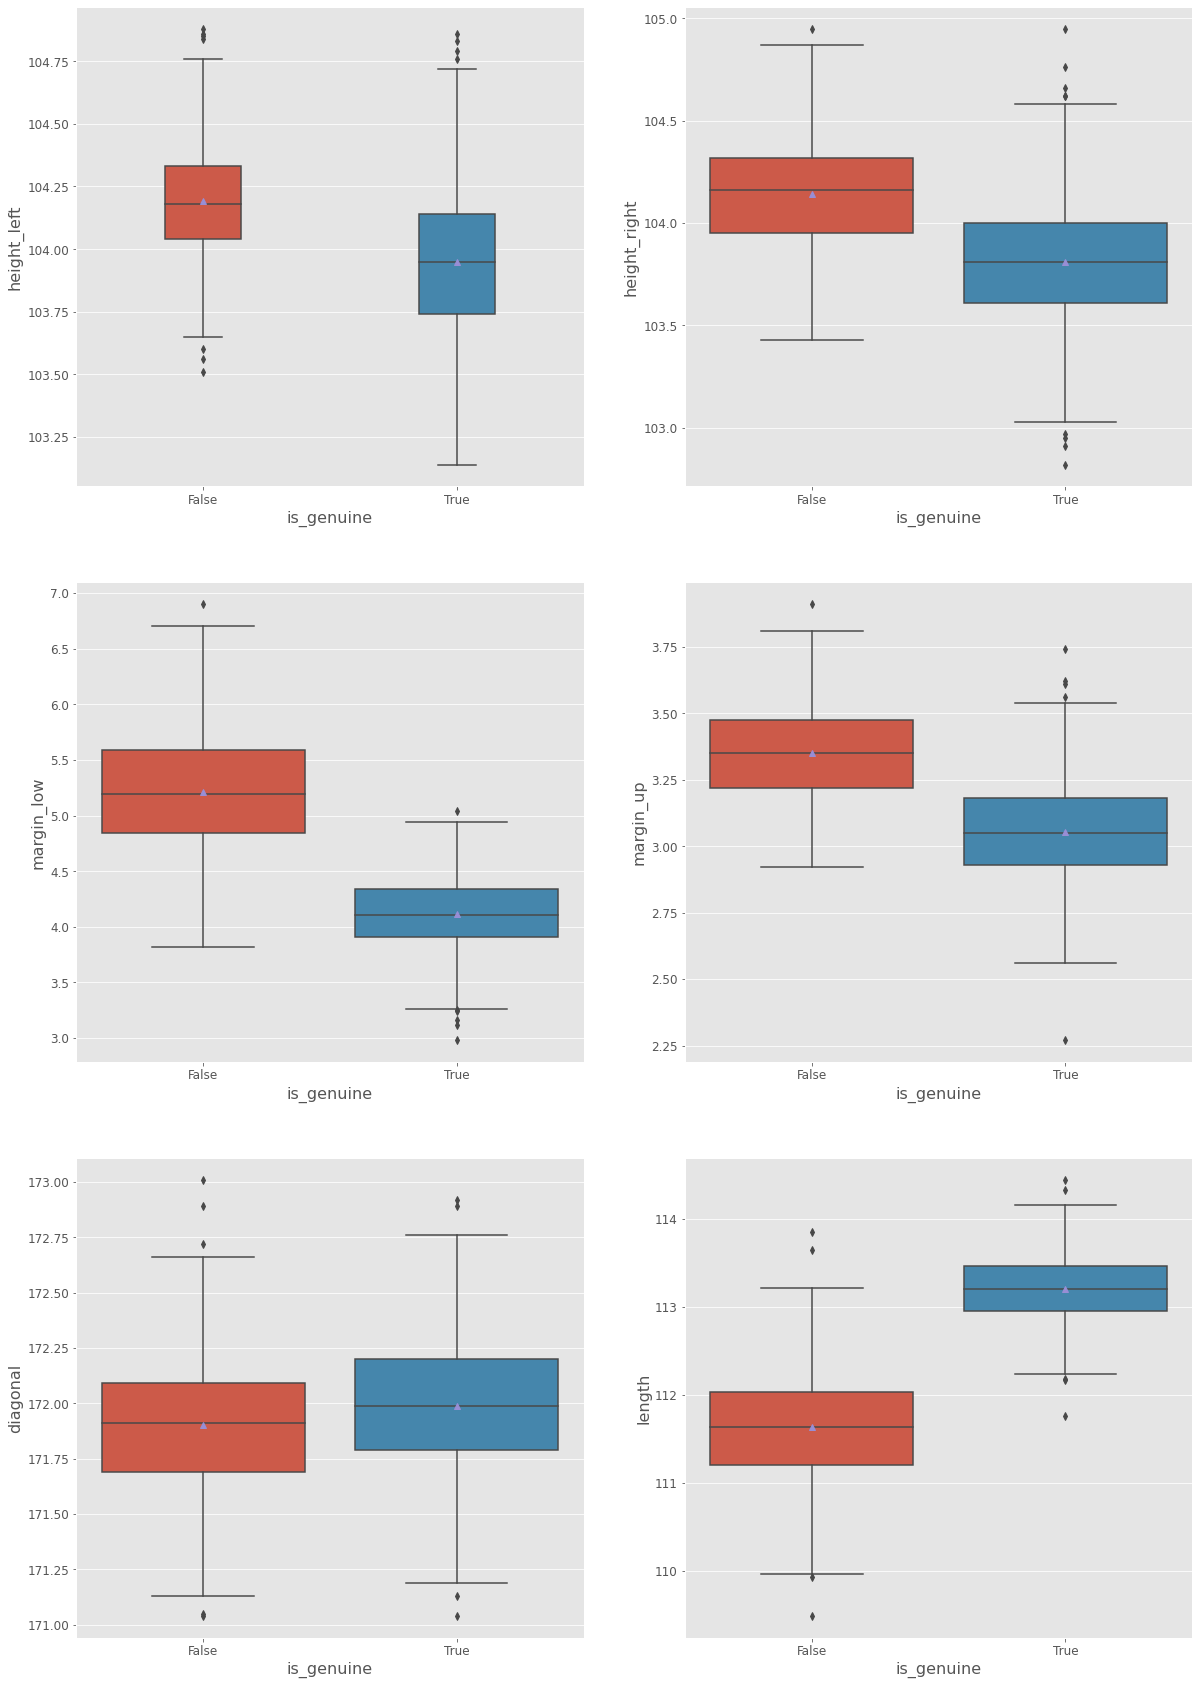

In [7]:
# boxplot de distribution des variables par rapport a la variables 'is_genuine'
plt.figure(figsize=(20, 30))
variables = billets.columns[1:]
plt.subplot(321)
sns.boxplot(x='is_genuine', y='height_left', width=0.3, data=billets, showmeans=True)
plt.subplot(322)
sns.boxplot(x='is_genuine', y='height_right', data=billets, showmeans=True)
plt.subplot(323)
sns.boxplot(x='is_genuine', y='margin_low', data=billets, showmeans=True)
plt.subplot(324)
sns.boxplot(x='is_genuine', y='margin_up', data=billets, showmeans=True)
plt.subplot(325)
sns.boxplot(x='is_genuine', y='diagonal', data=billets, showmeans=True)
plt.subplot(326)
sns.boxplot(x='is_genuine', y='length', data=billets, showmeans=True)

#plt.savefig("p6_graphic/boxplot_2.png")
plt.show()

Un premier constat peut-être fait :

* les variables `margin` et `height` ont des moyennes et médianes plus élevées pour les faux billets.
* la variable `length` a une moyenne et médiane plus basse pour les faux billets. 
* la variable `diagonal` ne semble pas être significative.  

Des outliers sont visibles, mais restent relativement proches des queues de distribution. Ces valeurs restent totalement acceptables, elles ne semblent pas représenter d'erreur particulière. Ces outliers seront conservés pour la suite de l'analyse.

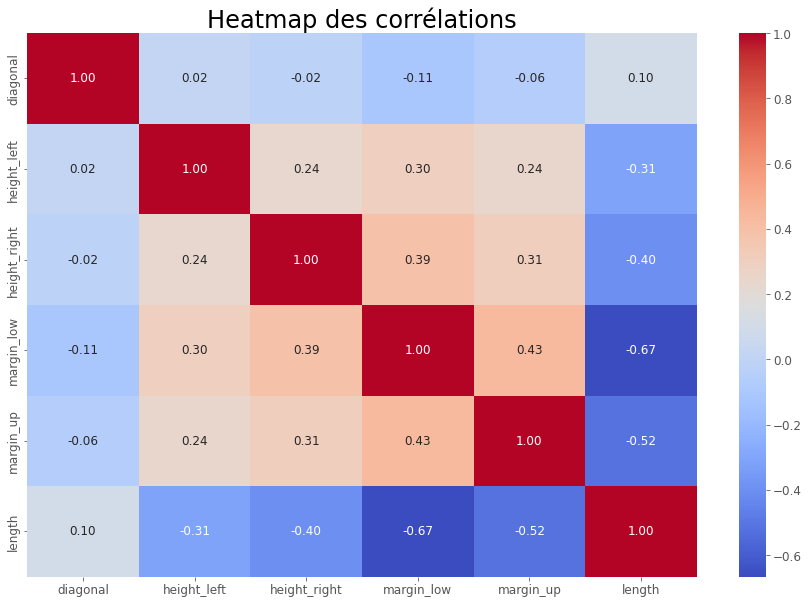

In [8]:
billets_df =billets.copy()
billets_df = billets_df.dropna()

#HeatMap des corrélations linéaires 
plt.figure(figsize=(15, 10))
sns.heatmap(billets_df.iloc[:, 1:].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Heatmap des corrélations')

#plt.savefig("p6_graphic/heatmap.png")
plt.show()

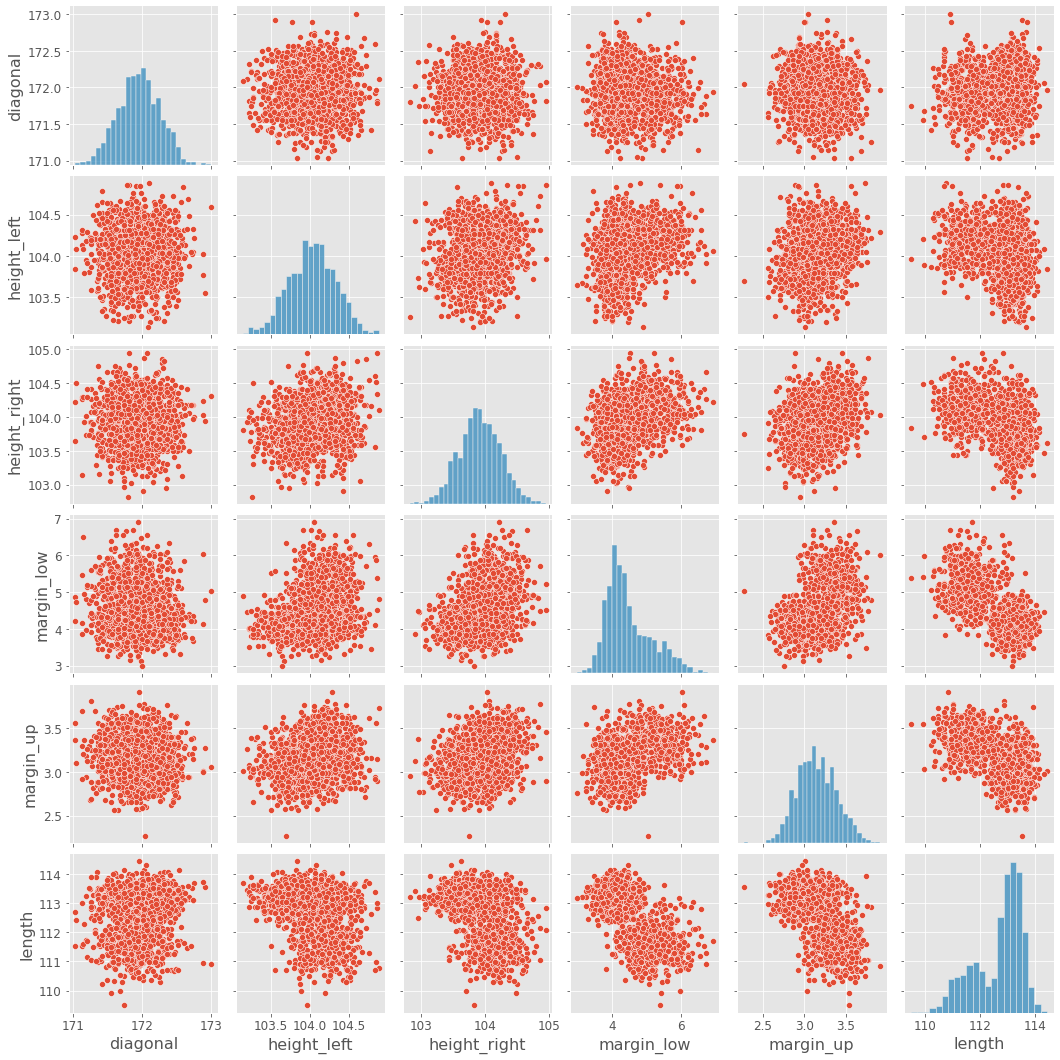

In [9]:
#Visualisation des correlations sous forme de pairplot
sns.pairplot(billets.iloc[:, 1:])

#plt.savefig("p6_graphic/pairplot.png")
plt.show()


**Observation:**
Il ressort alors une relation linéaire entre les deux variables `length` et `margin_low`, le coefficient de pearson égal à -0.67 est proche de -1, il existe donc une corrélation linéaire négative entre ces deux variable. Concrètement, au plus `length` aura une valeur élevée, au plus `margin_low` va diminuer.


On va se servir du fait que ces deux variables soient anti-corrélées pour estimer les 37 valeurs manquantes. Quel est le type de résultat on souhaite prédire ? Il s'agit bien d'un nombre qui représente la marge inférieure d'un billet de banque, `margin_low`, c'est donc un problème de régression. À partir d'une problématique et d'un dataset, nous avons considéré une hypothèse de travail pour contraindre le modèle : ici nous nous sommes placés dans le cas d'une régression linéaire simple, qui signifie contraindre la forme du modèle à une droite.

### Imputation par régression linéaire simple de la variable margin_low

In [10]:
# construction du dataset pour la regression lineaire
X = billets_df['length'][:, np.newaxis]
Y = billets_df['margin_low'][:, np.newaxis]
# entrainement du modele de regression lineaire
model = LinearRegression()
model.fit(X,Y)
y_predict = model.predict(X)

#### Verification des hypothèses de validité de la régression linéaire simple

Il s'agit de verifier si les hypothèses suivantes sont respectées :
1. La relation entre les deux variables numériques continues est réellement de forme linéaire (au moins grossièrement).
2. Les résidus de la régression linéaire sont indépendants.
3. Les résidus de la régression linéaire sont distribués selon une loi Normale de moyenne 0 (au moins grossièrement).
4. Les résidus de la régression linéaire sont distribués de façon homogène (homoscédasticité).

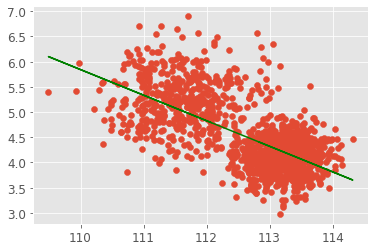

équation du modèle: Y = -0.51 X +  61.6
racine carrée de l'erreur quadratique moyenne:  0.49


In [11]:
# Modele de regression lineaire obtenu affiche sur le scatterplot
plt.scatter(X, Y, label ='y')
plt.plot(X, y_predict, color='g',label = 'model')
plt.show()

rmse_linear = np.sqrt(mean_squared_error(Y,y_predict))

a = round(float(model.coef_),2)
b = round(float(model.intercept_),2)
print('équation du modèle: Y =',a,'X + ',b)
print('racine carrée de l\'erreur quadratique moyenne: ', round(rmse_linear,2))

La linéarité peut être évaluée graphiquement grâce au scatterplot. La relation entre les deux variables numériques continues `length` et `margin_low` est de forme linéaire comme on peut le constater sur le diagramme de dispersion ci-dessus.  

**Vérifions maintenant si les résidus de la régression linéaire sont indépendants grâce au test de Durbin-Watson.**

In [12]:
from statsmodels.stats.stattools import durbin_watson
resid = Y - y_predict
float(durbin_watson(resid))

1.8655253979522612

La statistique de test est de 1.86, elle se situe dans la plage de 1.50 et 2.50, on considére que l'autocorrélation n'est pas problématique dans ce modèle de régression. On peut dire que les résidus sont indépendants.  

**On s'intéresse ensuite à la normalité des résidus:**

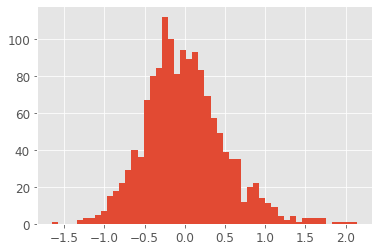

In [13]:
plt.hist(resid,bins=50)
plt.show()

Sans test à priori, les résidus de la régression linéaire peuvent sembler distribués selon une loi normale de moyenne 0 par observation de l'histogramme.

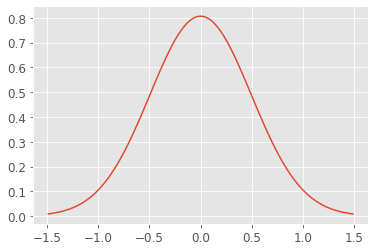

In [14]:
import scipy.stats as stats
import math

mu = np.mean(resid)
sigma = np.std(resid, ddof=1)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

On constate que l’écart entre l’histogrammme des résidus et la densité gaussienne sont plutôt proches. Toutefois, il faut tester la normalité des résidus avec un test de Shapiro-Wilk pour attester de sa normalité.

In [15]:
from scipy.stats import t, shapiro

stat, p = shapiro(resid)

print('Statistics=%.3f, p=%.12f' % (stat, p))

#Interprétation
alpha = 0.05
if p > alpha:
    print('On ne peut pas rejeter H0 pour des niveaux de test de 5%')
else:
    print('H0 est rejetée pour des niveaux de test de 5%')

Statistics=0.982, p=0.000000000002
H0 est rejetée pour des niveaux de test de 5%


Ici, l'hypothèse de normalité est remise en cause (p-value < 0.05). Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.

**On peut enfin tester l’homoscédasticité (c'est-à-dire la constance de la variance) des résidus :**

In [16]:
from statsmodels.formula.api import ols
model = ols('margin_low ~ length', data=billets_df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     1169.
Date:                Wed, 31 Aug 2022   Prob (F-statistic):          8.98e-189
Time:                        21:22:52   Log-Likelihood:                -1045.8
No. Observations:                1463   AIC:                             2096.
Df Residuals:                    1461   BIC:                             2106.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     61.5960      1.670     36.881      0.0

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

variables = model.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]
_, pval, __, f_pval = het_breuschpagan(model.resid, variables)
print('p value test Breusch Pagan:', pval)

p value test Breusch Pagan: 5.9965405710468075e-15


La p-valeur ici est inférieure à  5 %, on rejette l'hypothèse nulle  selon laquelle les variances sont constantes (l'hypothèse d’homoscédasticité présente). Le test de Breush-Pagan rejette donc l’hypothèse d’homogénéité des résidus.  

**La régression linéaire simple permet d’estimer les paramètres de la droite liant la variable `length` à la variable prédictive `margin_low`. Dans notre cas, on ne peut pas évaluer si cette relation est significative ou non à l'aide d'un test T car les 4 hypothèses de validité ne sont pas toutes satisfaites.**

#### Prédiction des valeurs manquantes avec une régression linéaire

In [18]:
billets_lr =billets.copy()
billets_lr['margin_low'].fillna(round(a*(billets_lr[billets_lr['margin_low'].isna()]['length'])+b,2),inplace=True)

In [19]:
# Vérification sur les index 72,99
billets_lr[(billets_lr.index==72) | (billets_lr.index==99) ]

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
72,True,171.94,103.89,103.45,4.08,3.25,112.79
99,True,171.93,104.07,104.18,3.93,3.14,113.08


In [20]:
billets_lr.isna().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

In [21]:
billets_lr.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.475427,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.662333,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.010000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.305000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.860000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


<div style="border: 1px solid RGB(150,100,200);" >
    <h1 style="margin: auto; padding: 20px; color: RGB(51,165,182); "> <a id="F"> 2 - MODELISATION </a></h1>
</div>

## KMeans

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X = billets_lr.drop('is_genuine', axis=1).copy()
y = billets_lr['is_genuine'].copy()

In [24]:
y = y.replace([True, False], [1,0])

In [25]:
y

0       1
1       1
2       1
3       1
4       1
       ..
1495    0
1496    0
1497    0
1498    0
1499    0
Name: is_genuine, Length: 1500, dtype: int64

In [26]:
X

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...
1495,171.75,104.38,104.17,4.42,3.09,111.28
1496,172.19,104.63,104.44,5.27,3.37,110.97
1497,171.80,104.01,104.12,5.51,3.36,111.95
1498,172.06,104.28,104.06,5.17,3.46,112.25


In [27]:
# Normalisation
X_scaled = preprocessing.StandardScaler().fit_transform(X)

In [28]:
X_scaled

array([[-0.48653957,  2.77412327,  3.16324041,  0.06731993, -1.128325  ,
         0.17365114],
       [-1.63372936, -2.23653528, -0.79966777, -1.06541896, -0.69679916,
         0.47166629],
       [ 2.3978233 ,  1.50475644, -1.29119126, -0.11391829, -0.91256208,
         0.55190114],
       ...,
       [-0.51931643, -0.06524991,  0.61346228,  1.56253527,  0.89984645,
        -0.83501554],
       [ 0.3328817 ,  0.83666863,  0.42914097,  1.04902697,  1.33137229,
        -0.4911519 ],
       [-1.6009525 ,  0.40241156, -0.30814427,  0.23345497,  0.94299904,
        -0.69747008]])

### Recherche du nombre optimal de K par la methode du coude

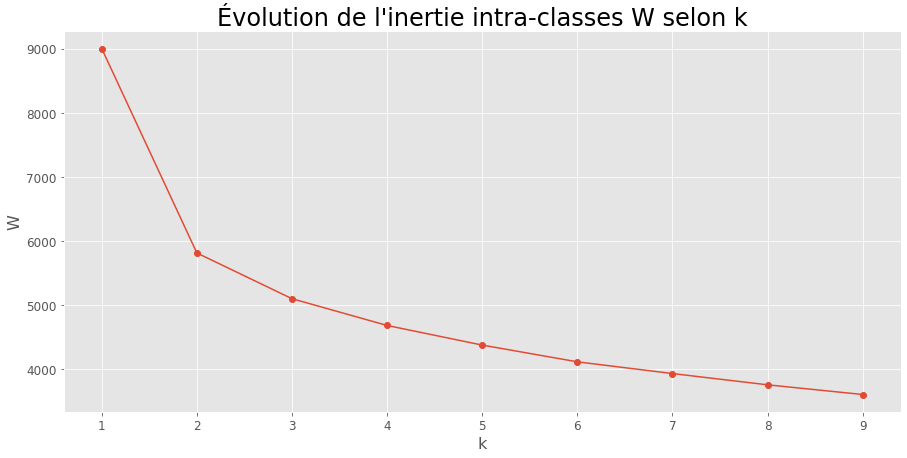

In [29]:
#Liste dans laquelle on stocke les inerties
inerties=[]

#Boucle de 1 à 9 pour tester ces possibiliéts
for k in range(1, 10):
    #pour chaque k, on crée un modèle et on l’ajuste
    km = cluster.KMeans(n_clusters=k)
    km.fit(X_scaled)
    #on stocke l’inertie associée
    inerties.append(km.inertia_)

#Visualisation des valeurs d'inertie pour chaque nombre de cluster
plt.figure(figsize=(15, 7))
plt.plot(range(1, 10), inerties, marker='o')
plt.xlabel('k')
plt.ylabel('W')
plt.title("Évolution de l'inertie intra-classes W selon k")

#plt.savefig("p6_graphic/kmeans_inertie.png")
plt.show()

**Observation:**
Par la méthode du coude, la confirmation d'un k=2 prend tout son sens.
En effet, l'ajout d'un ou plusieurs groupes n'apporterait pas d'information pertinente dans le contexte. Un k>2 serait possible dans la condition d'un jeu de données apportant une précision plus fine, comme par exemple dans la valorisation du billet, cela pourrait permettre de classifier les billets selon leur valeur en plus du type.

In [30]:
#Classification des billets pour un K-Means  a 2 clusters 
classification = cluster.KMeans(n_clusters=2) 
classification.fit(X_scaled)

KMeans(n_clusters=2)

In [31]:
classes = pd.DataFrame({'cluster':classification.labels_})
df_class = billets_lr.join(classes)
df_class

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,cluster
0,True,171.81,104.86,104.95,4.52,2.89,112.83,1
1,True,171.46,103.36,103.66,3.77,2.99,113.09,0
2,True,172.69,104.48,103.50,4.40,2.94,113.16,0
3,True,171.36,103.91,103.94,3.62,3.01,113.51,0
4,True,171.73,104.28,103.46,4.04,3.48,112.54,0
...,...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28,1
1496,False,172.19,104.63,104.44,5.27,3.37,110.97,1
1497,False,171.80,104.01,104.12,5.51,3.36,111.95,1
1498,False,172.06,104.28,104.06,5.17,3.46,112.25,1


## Analyse en composants principales

#### Eboulis des valeurs propres

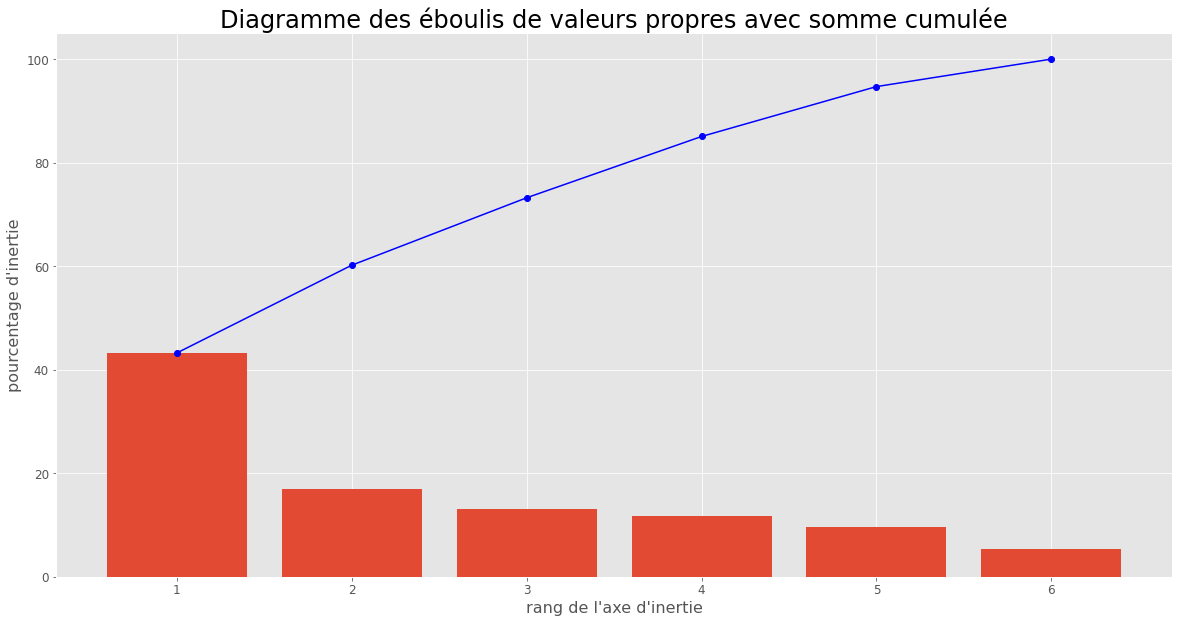

In [32]:
#Représentation de la variance expliquée: Diagramme des éboulis de valeurs propres avec somme cumulée
pca = decomposition.PCA()
pca.fit(X_scaled)
scree = pca.explained_variance_ratio_*100

plt.figure(figsize=(20,10))
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="blue",marker='o')
    
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Diagramme des éboulis de valeurs propres avec somme cumulée")

#plt.savefig("p6_graphic/eboulis_valeurs_propres.png")
plt.show()

Le diagramme des éboulis précise une représentation satisfaisante de nos variables **sur les deux premières composantes principales, le premier axe factoriel.**

#### Cercle des corrélations des variables sur le premier plan factoriel

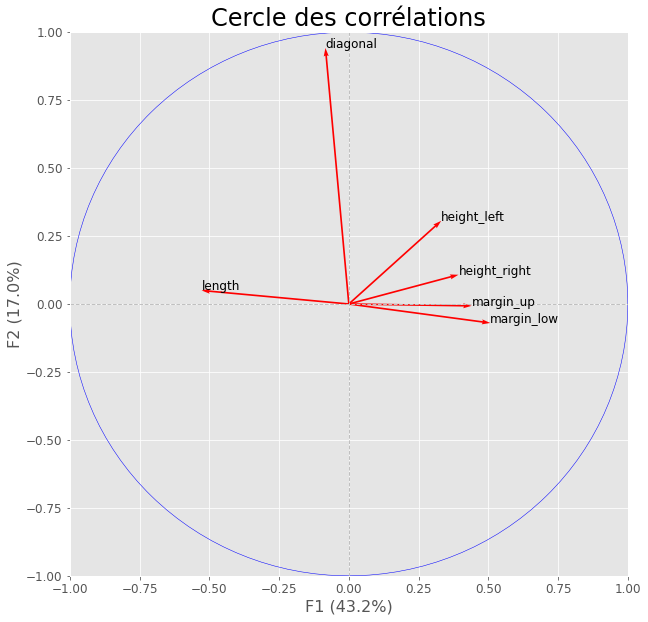

In [33]:
#Calcul des composantes principales sur les deux premières
pca = decomposition.PCA(n_components=2)
pca.fit(X_scaled)

pcs = pca.components_

fig = plt.subplots(figsize=(10,10))
plt.xlim(-1,1)
plt.ylim(-1,1)

plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
           pcs[0,:], pcs[1,:], angles='xy', scale_units='xy', scale=1, color='r', width= 0.003)

for i, (x, y) in enumerate(zip(pcs[0, :], pcs[1, :])):
    plt.text(x, y, billets.iloc[:,1:].columns[i])
    
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
plt.gca().add_artist(circle)

# Ajout des axes
plt.plot([-1,1],[0,0],color='silver',linestyle='--',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='--',linewidth=1)

plt.title('Cercle des corrélations')
plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))

#plt.savefig("p6_graphic/cercle_correlation.png")
plt.show()

**Observations:**
A partir de cette représentation graphique, nous pouvons déterminer les variables qui se révélent être les plus corrélées aux composantes F1 et F2. Notons également que la longueur des flèches est importante, une variable dont la longueur de la flèche est proche de 1 sera extrêmement bien représentée.

- La variable `diagonal` contribue fortement (et positivement) à l'axe 2

- Les variables `height_left` et `height_right` contribuent le plus et positivement à l'axe 1.

- Les variables `margin_up` et `margin_low` contribuent positivement à l'axe 1.

- La variable `lenght` contribue négativement à l'axe 1.

### Visualisation des deux clusters issues du KMeans dans le premier plan factoriel

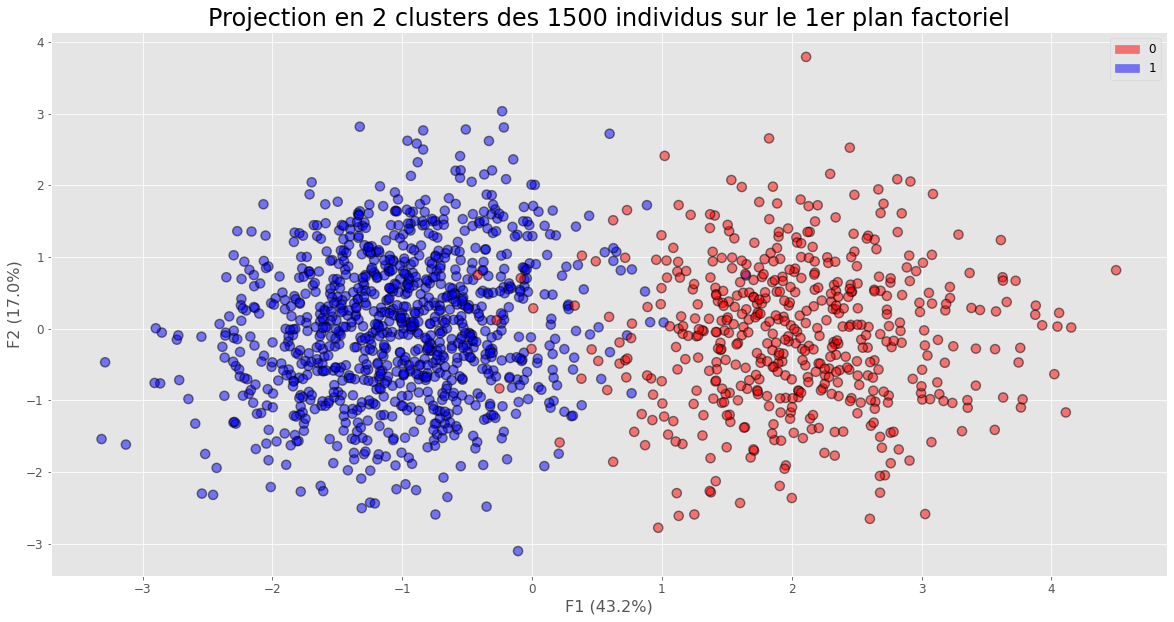

In [34]:
#Coordonnées factorielles 
X_projected = pca.transform(X_scaled)
plt.figure(figsize=(20, 10))


colors = ['red', 'blue']

plt.scatter(X_projected[:, 0], X_projected[:, 1], c=billets['is_genuine'].apply(lambda x: colors[x]), 
            alpha=0.5, edgecolors='black', linewidths=1.4, s=85)



lab_0 = mpatches.Patch(color='red', alpha=0.5, label='0')
lab_1 = mpatches.Patch(color='blue', alpha=0.5, label='1')


plt.legend(handles=[lab_0, lab_1])

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)))
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)))
plt.title("Projection en 2 clusters des {} individus sur le 1er plan factoriel".format(X_projected.shape[0]))

#plt.savefig("p6_graphic/projection_kmeans.png")
plt.show()

### Évaluation du modèle à l'aide de la matrice de confusion.

In [35]:
tab = pd.crosstab(df_class['cluster'],df_class['is_genuine'],margins=True,margins_name = 'Total')
confusion_matrix =  pd.crosstab(df_class['cluster'],df_class['is_genuine'])
tab

is_genuine,False,True,Total
cluster,,,
0,13,990,1003
1,487,10,497
Total,500,1000,1500


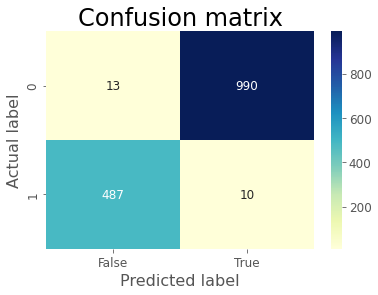

In [36]:
#Représentation graphique de la Matrice de confusion
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')

plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## Regression Logistic

In [37]:
#Séparation entre les données d'entrainement et les données test
from sklearn.linear_model import LogisticRegression

X = billets_lr.drop('is_genuine', axis=1).copy()
y = billets_lr['is_genuine'].copy()
y = y.replace([True, False], [1,0])

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.20)

print('Train set: ',X_train.shape)
print('Test set: ',X_test.shape)

Train set:  (1200, 6)
Test set:  (300, 6)


In [38]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)
print('Train score: ',  round(lr.score(X_train,Y_train),2))
print('Test score: ',  round(lr.score(X_test,Y_test),2))

Train score:  0.99
Test score:  0.99


[[ 85   1]
 [  2 212]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        86
           1       1.00      0.99      0.99       214

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



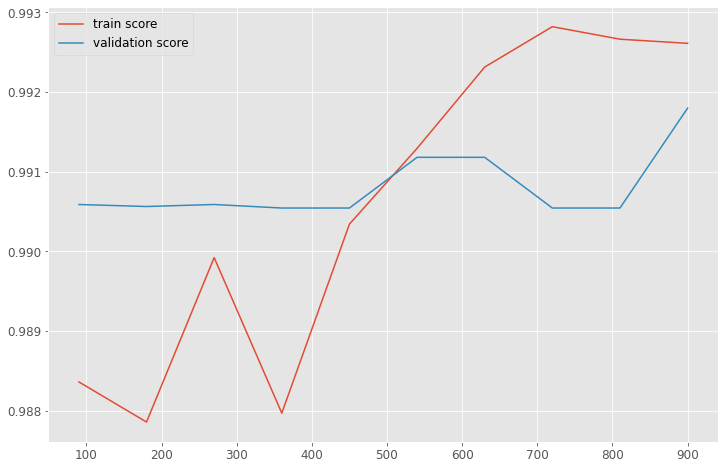

In [39]:
# Evaluation du modele
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve

lr = LogisticRegression()
lr.fit(X_train, Y_train)
ypred = lr.predict(X_test)

print(confusion_matrix(Y_test, ypred))
print(classification_report(Y_test, ypred))

N, train_score, val_score = learning_curve(lr, X_train, Y_train,
                                          cv=4, scoring='f1',
                                           train_sizes=np.linspace(0.1, 1, 10))


plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.legend()

### L'évaluation du modèle peut aussi se faire par la courbe ROC et sa métrique AUC.

La courbe ROC (Receiver Operating Characteristic) représente la sensibilité en fonction de la spécificité pour différents seuils de décision. L'aire sous la courbe ROC, l'AUC (Area Under the ROC ), est une mesure de la qualité de la classification qui varie entre 0.5 dans le pire des cas et 1 dans le meilleur des cas.

In [40]:
from sklearn.metrics import roc_curve, auc
#Récupération de la prédiction de la valeur positive
y_prob = lr.predict_proba(X_test)[:,1] 
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_prob)
#Mesure AUC (Area Under the Curve): Aire sous la courbe
from sklearn import metrics
metrics.auc(false_positive_rate, true_positive_rate)

0.9997826559443599

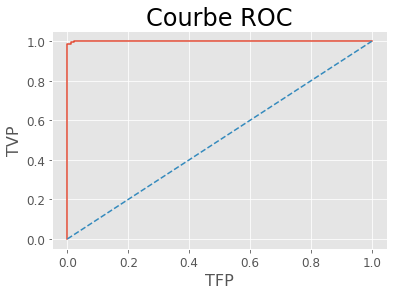

In [41]:
#Courbe ROC
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlabel('TFP')
plt.ylabel('TVP')
plt.title('Courbe ROC')

#plt.savefig("p6_graphic/courbe_roc.png")
plt.show()